In [1]:
import os
import glob
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
%matplotlib inline
import matplotlib
import cartopy.crs as ccrs
matplotlib.rcParams.update({'font.size':15})

import sys
p = os.path.abspath('/global/homes/q/qnicolas/')
if p not in sys.path:
    sys.path.append(p)

from tools.wrfHrTools import *
xr.set_options(display_style='text') 

%load_ext autoreload
%autoreload 2

In [2]:
import dask
dask.config.config["distributed"]["dashboard"]["link"] = "{JUPYTERHUB_SERVICE_PREFIX}proxy/{port}/status"
from dask.distributed import Client
client=Client(n_workers=4,threads_per_worker=4)
client

Client Scheduler: tcp://127.0.0.1:38879 Dashboard: /user/qnicolas/cori-shared-node-cpu/proxy/8787/status,Cluster Workers: 4 Cores: 16 Memory: 540.14 GB


In [1]:
import sys;import os
p = '/global/homes/q/qnicolas'
if p not in sys.path:
    sys.path.append(p)
from tools.wrfHrTools import *
import xarray as xr

scratch = "/global/cscratch1/sd/qnicolas/"
#scratch = "/pscratch/sd/q/qnicolas/"
path = scratch+"wrfdata/saved/"
sims = ["channel.wrf.100x2.mountain.60lev.500m.12mps.3km",
        "channel.wrf.100x2.mountain.60lev.500m.12mps.new.3km",
        "channel.wrf.100x2.mountain.60lev.500m.296K.3km",
        "channel.wrf.100x2.mountain.60lev.500m.296K.new.3km",
        "channel.wrf.100x2.mountain.60lev.500m.3km",
        "channel.wrf.100x2.mountain.60lev.500m.new.3km",
        "channel.wrf.100x2.mountain.60lev.500m.new2.3km",
        ]

for i,sim in enumerate(sims):
    try:
        test = extract_wrfout(path+sim+'/')
    except OSError:
        print('no wrfout - %s'%sim)
    try:
        test = extract_wrfpro(path+sim+'/')
    except OSError:
        print('no wrfpout - %s'%sim)
    try:
        for file in os.listdir(path+sim+"/diags/"):
            try:
                test = xr.open_dataset(path+sim+"/diags/"+file)
            except OSError:
                try:
                    test = xr.open_zarr(path+sim+"/diags/"+file)
                except:
                    print("Could not open "+ path+sim+"/diags/"+file)
    except FileNotFoundError:
        print('no diags - %s'%sim)
                
    try:
        test = xr.open_dataset(path+sim+"/wrfinput_d01")
    except:
        print('no input - %s'%sim)        
for path in (scratch+"WRF/WRFV4_channel/test/em_beta_plane/",scratch+"WRF/WRFV4_channel12/test/em_beta_plane/",scratch+"WRF/WRFV4_channel296/test/em_beta_plane/"):
    rsts = glob.glob(path+'wrfrst*')
    for rst in rsts:
        test=  xr.open_dataset(rst)    
  


no wrfout - channel.wrf.100x2.mountain.60lev.500m.12mps.3km
no wrfpout - channel.wrf.100x2.mountain.60lev.500m.12mps.3km
no diags - channel.wrf.100x2.mountain.60lev.500m.12mps.3km
no input - channel.wrf.100x2.mountain.60lev.500m.12mps.3km
no wrfpout - channel.wrf.100x2.mountain.60lev.500m.12mps.new.3km
no diags - channel.wrf.100x2.mountain.60lev.500m.12mps.new.3km
no wrfout - channel.wrf.100x2.mountain.60lev.500m.296K.3km
no wrfpout - channel.wrf.100x2.mountain.60lev.500m.296K.3km
no diags - channel.wrf.100x2.mountain.60lev.500m.296K.3km
no input - channel.wrf.100x2.mountain.60lev.500m.296K.3km
no wrfpout - channel.wrf.100x2.mountain.60lev.500m.296K.new.3km
no diags - channel.wrf.100x2.mountain.60lev.500m.296K.new.3km
no wrfout - channel.wrf.100x2.mountain.60lev.500m.3km
no wrfpout - channel.wrf.100x2.mountain.60lev.500m.3km
no diags - channel.wrf.100x2.mountain.60lev.500m.3km
no input - channel.wrf.100x2.mountain.60lev.500m.3km
no diags - channel.wrf.100x2.mountain.60lev.500m.new.3km


In [113]:
W10S300.W_PL_mean   = change_coords_pl(W10S300.datapl,xr.open_dataarray(W10S300.path+'diags/wrf.W_PL.days50-200.nc'))
W10S300.T_PL_mean   = change_coords_pl(W10S300.datapl,xr.open_dataarray(W10S300.path+'diags/wrf.T_PL.days50-200.nc'))
W10S300.Q_PL_mean   = change_coords_pl(W10S300.datapl,xr.open_dataarray(W10S300.path+'diags/wrf.Q_PL.days50-200.nc'))
W10S300.GHT_PL_mean = change_coords_pl(W10S300.datapl,xr.open_dataarray(W10S300.path+'diags/wrf.GHT_PL.days50-200.nc'))
W10S300.MSE_mean    = 1004*W10S300.T_PL_mean + 2.5e6*W10S300.Q_PL_mean + 9.81*W10S300.GHT_PL_mean
W10S300.DSE_mean    = 1004*W10S300.T_PL_mean + 9.81*W10S300.GHT_PL_mean

In [123]:
W10S300.PRECIP_HOURLY = W10S300.datapl.RAINNC.diff('Time')*24

In [125]:
w_condmean = W10S300.datapl.W_PL[2400:4800].where(W10S300.PRECIP_HOURLY[2400:4800]>5).mean(['Time','south_north']).load()

In [126]:
w_condmean = change_coords_pl(W10S300.datapl,w_condmean)

In [91]:
surface_mean_dse = 1004*W10S300.datapl.T2.mean(['Time','south_north']) + 9.81*W10S300.data.HGT[0].mean(['Time','south_north'])
surface_mean_dse = change_coords_sfc(surface_mean_dse.load())
surface_mean_mse = surface_mean_dse + 2.5e6*change_coords_sfc(W10S300.datapl.Q2.mean(['Time','south_north']))
surface_mean_mse = surface_mean_mse.load()



In [114]:
# filter nan values
w_condmean = w_condmean.where(w_condmean>-2).fillna(0.)
W10S300.MSE_mean = W10S300.MSE_mean.where(W10S300.MSE_mean>3.1e5).fillna(surface_mean_mse)
W10S300.DSE_mean = W10S300.DSE_mean.where(W10S300.DSE_mean>2.7e5).fillna(surface_mean_dse)

In [140]:
Sim=W10S300

# Functions, data loading

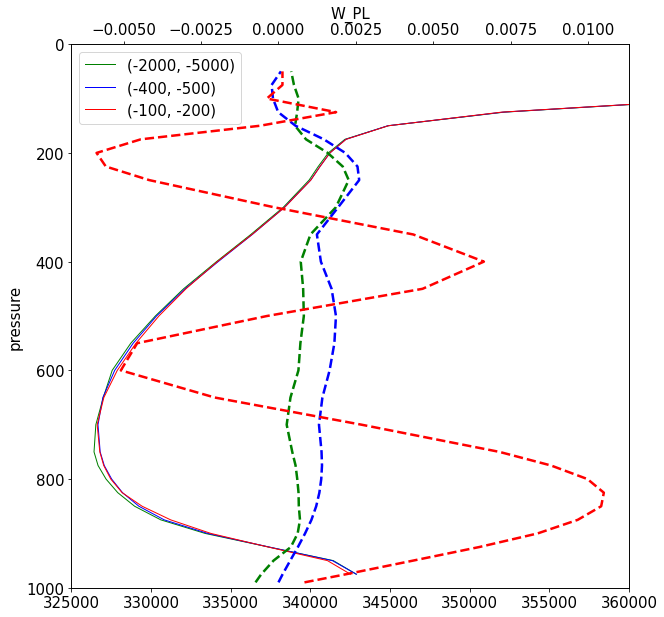

In [57]:
_,ax=plt.subplots(1,1,figsize=(10,10))
ax2=ax.twiny()
colors = ['g','b','r']
slices = [(-2000,-5000),(-400,-500),(-100,-200)]
scales = (10,1,1)
Sim = W10S300

for sl,clr,scale in zip(slices,colors,scales):
    Sim.MSE_mean.sel(distance_from_mtn=slice(*sl)).mean('distance_from_mtn').plot(ax=ax,y='pressure',color=clr,linewidth=1,label=str(sl))
    (scale*Sim.W_PL_mean).sel(distance_from_mtn=slice(*sl)).mean('distance_from_mtn').plot(ax=ax2,y='pressure',color=clr,linewidth=2.5,linestyle='--')
ax.set_xlim(325e3,360e3)
ax.set_ylim(1000,0)
ax.legend()

In [141]:
for sl,clr,scale in zip(slices,colors,scales):
    w = Sim.W_PL_mean.sel(distance_from_mtn=slice(*sl)).mean('distance_from_mtn').fillna(0.)
    mse = Sim.MSE_mean.sel(distance_from_mtn=slice(*sl)).mean('distance_from_mtn')
    
    normalized_w =  w.sel(pressure=slice(1000,100))/(w.sel(pressure=slice(1000,100)).integrate('pressure')/900)
    GMS = -(mse.sel(pressure=slice(1000,100)).differentiate('pressure') * normalized_w).integrate('pressure')
    print("{:<11} : {:.2f} J/kg".format(str(sl),float(GMS)))

(-2000, -5000) : 5486.53 J/kg
(-400, -500) : 6574.10 J/kg
(-100, -200) : 185.66 J/kg


Text(0.5, 1.0, 'W on precipitating times')

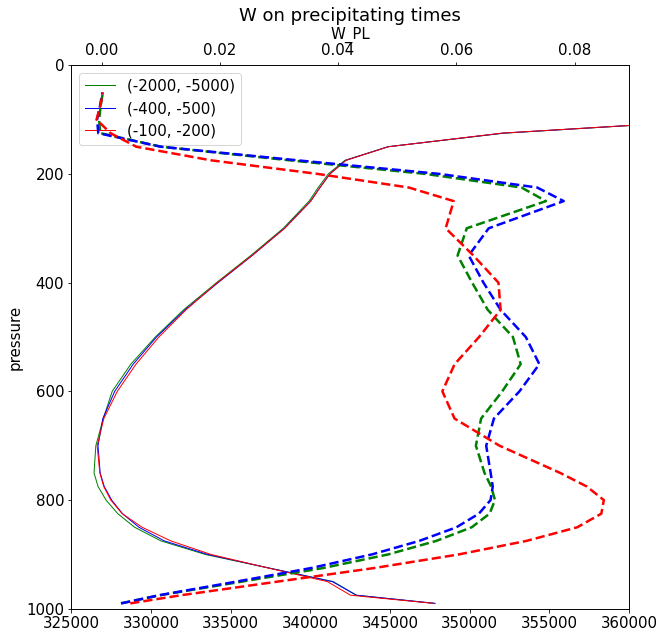

In [127]:
_,ax=plt.subplots(1,1,figsize=(10,10))
ax2=ax.twiny()
colors = ['g','b','r']
slices = [(-2000,-5000),(-400,-500),(-100,-200)]
Sim = W10S300

for sl,clr,scale in zip(slices,colors,scales):
    Sim.MSE_mean.sel(distance_from_mtn=slice(*sl)).mean('distance_from_mtn').plot(ax=ax,y='pressure',color=clr,linewidth=1,label=str(sl))
    w_condmean.sel(distance_from_mtn=slice(*sl)).mean('distance_from_mtn').plot(ax=ax2,y='pressure',color=clr,linewidth=2.5,linestyle='--')
ax.set_xlim(325e3,360e3)
ax.set_ylim(1000,0)
ax.legend()
ax.set_title("W on precipitating times")

In [141]:
for sl,clr,scale in zip(slices,colors,scales):
    w = w_condmean.sel(distance_from_mtn=slice(*sl)).mean('distance_from_mtn').fillna(0.)
    mse = Sim.MSE_mean.sel(distance_from_mtn=slice(*sl)).mean('distance_from_mtn')
    
    normalized_w =  w.sel(pressure=slice(1000,100))/(w.sel(pressure=slice(1000,100)).integrate('pressure')/900)
    GMS = -(mse.sel(pressure=slice(1000,100)).differentiate('pressure') * normalized_w).integrate('pressure')
    print("{:<11} : {:.2f} J/kg".format(str(sl),float(GMS)))

(-2000, -5000) : 5486.53 J/kg
(-400, -500) : 6574.10 J/kg
(-100, -200) : 185.66 J/kg


In [142]:
for sl,clr,scale in zip(slices,colors,scales):
    w = w_condmean.sel(distance_from_mtn=slice(*sl)).mean('distance_from_mtn')
    mse = Sim.MSE_mean.sel(distance_from_mtn=slice(*sl)).mean('distance_from_mtn')
    dse = Sim.DSE_mean.sel(distance_from_mtn=slice(*sl)).mean('distance_from_mtn')
    
    normalized_w =  w.sel(pressure=slice(1000,100))/(w.sel(pressure=slice(1000,100)).integrate('pressure')/900)
    GMS = -(mse.sel(pressure=slice(1000,100)).differentiate('pressure') * normalized_w).integrate('pressure')
    GDS = -(dse.sel(pressure=slice(1000,100)).differentiate('pressure') * normalized_w).integrate('pressure')
    print("{:<11} : {:.2f}".format(str(sl),float(GMS/GDS)))

(-2000, -5000) : 0.11
(-400, -500) : 0.14
(-100, -200) : 0.00


In [149]:
normalized_w =  w_condmean.sel(pressure=slice(1000,100))/(w.sel(pressure=slice(1000,100)).integrate('pressure')/900)
GMS = -(Sim.MSE_mean.sel(pressure=slice(1000,100)).differentiate('pressure') * normalized_w).integrate('pressure')
GDS = -(Sim.DSE_mean.sel(pressure=slice(1000,100)).differentiate('pressure') * normalized_w).integrate('pressure')


Text(0.5, 1.0, 'GMS, J/kg')

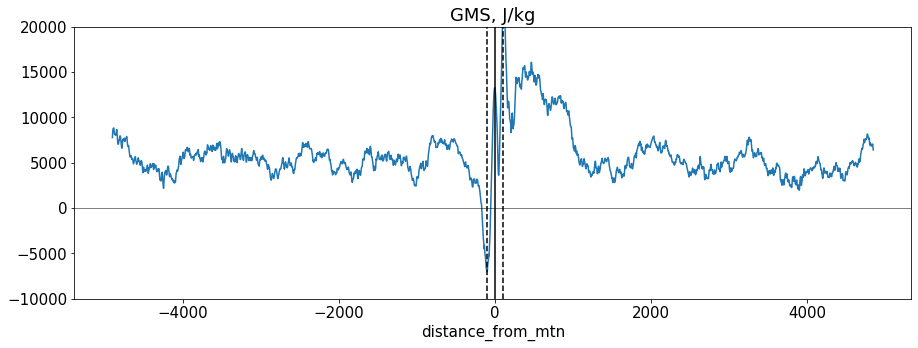

In [152]:
plt.figure(figsize=(15,5))
GMS.rolling(distance_from_mtn=20).mean().plot()
plt.axvline(-100,color='k',linestyle='--')
plt.axvline(100,color='k',linestyle='--')
plt.axvline(0,color='k')
plt.ylim(-1e4,2e4)
plt.axhline(0,color='k',linewidth=0.5)
plt.title('GMS, J/kg')

Text(0.5, 1.0, 'GMS/GDS')

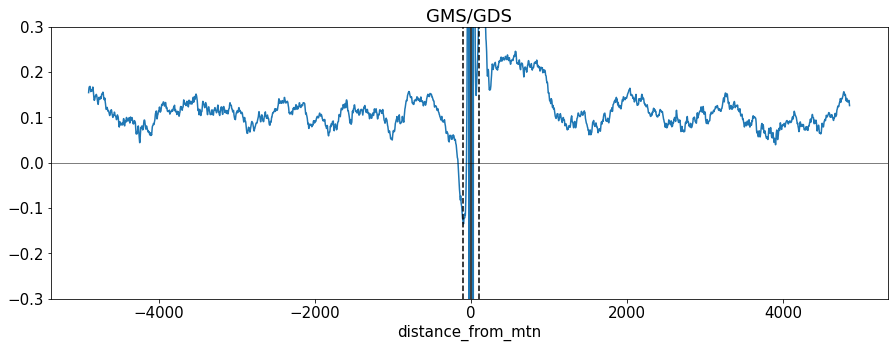

In [153]:
plt.figure(figsize=(15,5))
(GMS/GDS).rolling(distance_from_mtn=20).mean().plot()
plt.axvline(-100,color='k',linestyle='--')
plt.axvline(100,color='k',linestyle='--')
plt.axvline(0,color='k')
plt.axhline(0,color='k',linewidth=0.5)
plt.ylim(-0.3,0.3)
plt.title('GMS/GDS')

# Modifying the moisture profile

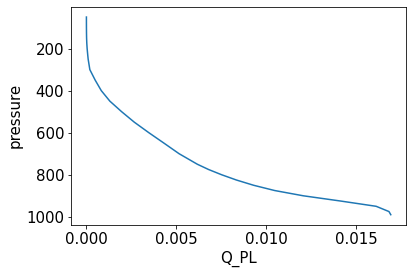

In [156]:
qprof = Sim.Q_PL_mean.mean('distance_from_mtn')
qprof.plot(y='pressure',yincrease=False)

In [159]:
MSE_diff = Sim.MSE_mean + 2.5e6*0.2*qprof
GMS_new = -(MSE_diff.sel(pressure=slice(1000,100)).differentiate('pressure') * normalized_w).integrate('pressure')


Text(0.5, 1.0, 'GMS, J/kg')

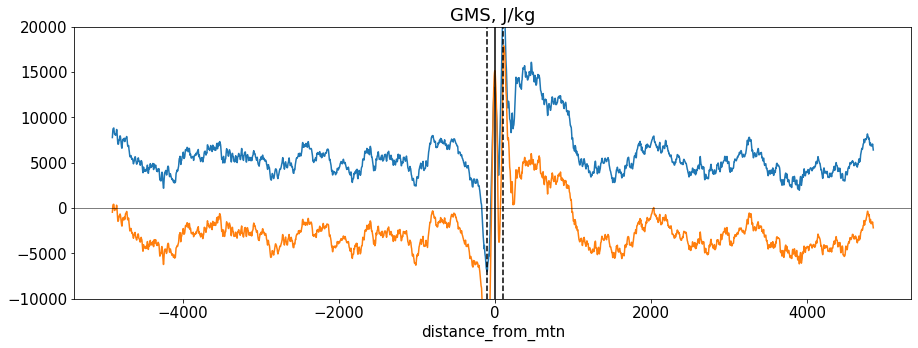

In [160]:
plt.figure(figsize=(15,5))
GMS.rolling(distance_from_mtn=20).mean().plot()
GMS_new.rolling(distance_from_mtn=20).mean().plot()
plt.axvline(-100,color='k',linestyle='--')
plt.axvline(100,color='k',linestyle='--')
plt.axvline(0,color='k')
plt.ylim(-1e4,2e4)
plt.axhline(0,color='k',linewidth=0.5)
plt.title('GMS, J/kg')